In [7]:
from gensim.models import FastText
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fasttext

In [9]:
corpus_fname = 'natepann.txt'
model_fname = 'fasttext'


print('corpus 생성')
corpus = [sent.strip().split(" ")for sent in tqdm(open(corpus_fname, 'r', encoding='utf-8').readlines())]

print("학습 중")
model = FastText(corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1)
model.save(model_fname)
print('완료')

100%|█████████████████████████████████████████████████████████████████████████████| 801/801 [00:00<00:00, 85408.72it/s]

corpus 생성
학습 중


완료


In [10]:
loaded_model = FastText.load("fasttext")
print(model.wv.vectors.shape)

(1671, 100)


In [4]:
print(loaded_model.wv.most_similar("스우파", topn=10))

[('모니카', 0.9994255304336548), ('립제이', 0.9993626475334167), ('로잘린', 0.999346137046814), ('라치카', 0.9992579817771912), ('웨이비', 0.999199390411377), ('시미즈', 0.9991756677627563), ('허니제이', 0.9991698265075684), ('마스카라', 0.999142587184906), ('올라온', 0.999104917049408), ('김민주', 0.999099850654602)]


In [5]:
print(loaded_model.wv.most_similar("재난지원금", topn=10))

[('오랜만에', 0.9997783899307251), ('안되는', 0.9997600317001343), ('모르겠지만', 0.9997597336769104), ('모르겠다', 0.999754786491394), ('안되냐고', 0.9997509717941284), ('와이프는', 0.9997484683990479), ('아니더라도', 0.9997484683990479), ('상황을', 0.9997460842132568), ('결혼할때', 0.9997426271438599), ('있지만', 0.9997420907020569)]


# 각 연관 단어가 포함된 텍스트 덩어리의 극성값 

연관 단어를 10-15개 추출하고, 새로운용어 + 연관단어 두가지가 모두 포함된 문장들만 추출하여 그 문장들의 감성분석을 진행하여 극성값을 추출한다. 

In [6]:
import re
import io
import json
import csv
import openpyxl
import pandas as pd
import numpy as np
import kss
import ast
from konlpy.tag import Komoran
from IPython.core.display import display, HTML
from konlpy.tag import Okt

In [23]:
Similar = []
similar_word_list = list(loaded_model.wv.most_similar("스우파", topn=10)) 

for i in range(len(similar_word_list)):
    temp_str = similar_word_list[i][0].__str__()
    Similar.append(temp_str)
    
print(Similar)

['모니카', '립제이', '로잘린', '라치카', '웨이비', '시미즈', '허니제이', '마스카라', '올라온', '김민주']


In [110]:
fkey = '스우파'
key = '모니카'

In [113]:
final = pd.DataFrame(columns = ['contents'])

f = pd.read_csv('natepann.csv')

is_key = (f['본문'].str.contains(fkey, na=False) | f['제목'].str.contains(fkey, na=False)) & (f['본문'].str.contains(key, na=False) | f['제목'].str.contains(key, na=False))

f_key = f[is_key]
f_key = f_key.reset_index()
f_key

final_key = pd.DataFrame(columns = ['tokenized'])

komoran = Komoran()

for i in range(len(f_key)):
    try:
        st = f_key.loc[i, '제목']
        final_key.loc[i, 'tokenized'] = str(st)
        ct = f_key.loc[i, '본문']
        final_key.loc[i, 'tokenized'] += str(ct)
        
    except KeyError:
        print("error")

keyword_content = pd.DataFrame(columns = ['content','positive', 'negative', 'neutral'])


for i in range(len(final_key)):
    try:
        fc = final_key.loc[i, 'tokenized']
        
        if i == 0:
            keyword_content.loc[0,'content'] = fc
        else:
            keyword_content.loc[0,'content'] += fc
        
    except KeyError:
        print("error")

keyword_content

# 감성사전에서 감성분석
f = open('SentiWord_Dict.txt', 'r', -1, 'utf-8')
lines = f.readlines()

score_dict = []

for line in lines:
    line_splited = line.split()
    score = int(line_splited[-1])
    word = ''
    for frac in line_splited[:-1]:
        word = word + ' ' + frac
    
    word = word[1:]
    score_dict.append([word, score])
    
keyword_content['positive'] = 0
keyword_content['negative'] = 0
keyword_content['neutral'] = 0

if keyword_content.empty:
    print("사전과 비교할 조건에 맞는 내용 없음")

else:
    keyword_content.loc[0, 'content'] = str(komoran.nouns(keyword_content.loc[0, 'content']))


    stopwords = ['하다', '없다', '있다', '되다', '아니다', '같다', '이다', '않다', '그렇다', 
                 '이렇다', '싶다', '다', '것', '그', '이', '거', '니다']


    pos_list = ast.literal_eval(keyword_content.loc[0, 'content'])

    final = []

    for j in range(len(pos_list)):
        if pos_list[j] not in stopwords:
            final.append(pos_list[j])

    keyword_content.loc[0, 'content'] = str(final)

    # 감성사전에서 감성분석
    f = open('SentiWord_Dict.txt', 'r', -1, 'utf-8')
    lines = f.readlines()

    score_dict = []

    for line in lines:
        line_splited = line.split()
        score = int(line_splited[-1])
        word = ''
        for frac in line_splited[:-1]:
            word = word + ' ' + frac

            word = word[1:]
            score_dict.append([word, score])

    keyword_content.insert(0, "Keyword", key)

    tokens = ast.literal_eval(keyword_content.loc[0, 'content'])

    try:
        for token in tokens:
            for dict_word in score_dict:
                if dict_word[0] == token:
                    if dict_word[1] > 0:
                        keyword_content.loc[0, 'positive'] += dict_word[1]
                    elif dict_word[1] < 0:
                        keyword_content.loc[0, 'negative'] += dict_word[1]
                    else:
                        keyword_content.loc[0, 'negative'] += 1 #중립어는 개수 세기    
    except KeyError:
        print("error")

print("연관 단어 :" + fkey)
keyword_content[keyword_content.columns.difference(['content'])]

연관 단어 :스우파


,Keyword,negative,neutral,positive
0,모니카,-21,0,12


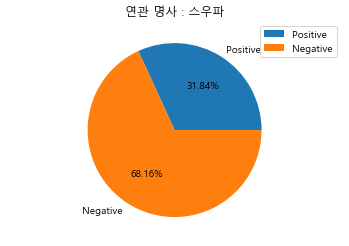

예시 문장 : 신정우 모니카 세상 무서운 캐릭인 줄 알았는데 트윗 완전 귀여움저번주부터 트위터 깔고 소통하면서 완전 신나심


In [124]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform

#iteration 만들기 이전 => 수동 합계

#한글 꺠짐 처리
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False
pos = str(12 + 12 + 6 + 6+ 2 + 13 + 13)
neg = str(-21 -23 -16 -17 -14 -17 -29).replace("-", "")

size = [pos, neg]

label = ['Positive','Negative']

plt.axis('equal')
plt.pie(x=size, labels=label, autopct='%.2f%%')

plt.title("연관 명사 : " + fkey)
plt.legend(loc="upper right")
plt.show()

print("예시 문장 : " + f_key.loc[0, '본문'])

# 각 연관 단어 1:1 사전 비교 극성값

각 단어별 사전과 비교시 아예 검색이 되지 않는 경우가 너무 많음, 형태적으로 사전에 등록되지 않은 내용이 많아서 1:1 매핑이 어려움.

In [37]:
Similar = []
similar_word_list = list(loaded_model.wv.most_similar("스우파", topn=100)) 

for i in range(len(similar_word_list)):
    temp_str = similar_word_list[i][0].__str__()
    Similar.append(temp_str)
    
print(Similar)

['모니카', '립제이', '로잘린', '라치카', '웨이비', '시미즈', '허니제이', '마스카라', '올라온', '김민주', '광고', '첫번째', '환승연애', '팬들이', '안유진', '떠난', '끝나고', '이채연', '시간에', '재계약을', '리헤이', '하루종일', '데리고', '가게를', '걸서위', '반응이', '아이들이', '한국에', '사서', '역시', '하려고', '당일', '사랑해', '인스타', '최유정', '방금', '나은은', '없다는', '보아', '몰라서', '말고도', '이유를', '엠마', '한번뿐인', '바빠서', '방법이', '보이는', '하도', '있도록', '중간중간', '잘린', '따라', '갖고', '베트남', '예쁜', '만원을', '프라우드먼', '아직까지', '받아', '화이팅', '지원을', '서울대', '아이는', '음식을', '사이', '보니까', '사진도', '나머지', '마름', '블로그', '당연히', '초반', '해야할지', '평범한', '추천', '없던', '좋겠다', '만드는', '병원에서', '가까이', '코로나가', '년간', '기다리고', '봐서', '이라', '좋지', '애기', '해주고', '베트남에', '판에', '그나마', '안됨', '년동안', '시댁에서', '마크', '마시고', '한국으로', '대부분', '하루', '백신을']


In [38]:
word_senti = pd.DataFrame(columns = ['positive', 'negative', 'neutral'])

In [39]:
w= '바빠서'
word_senti.insert(0, "Word", w)

In [40]:
word_senti.loc[0, 'positive'] = 0
word_senti.loc[0, 'negative'] = 0
word_senti.loc[0, 'neutral'] = 0

try:
    for dict_word in score_dict:
        if dict_word[0] == w:
            if dict_word[1] > 0:
                word_senti.loc[0, 'positive'] += dict_word[1]
            elif dict_word[1] < 0:
                word_senti.loc[0, 'negative'] += dict_word[1]
            else:
                word_senti.loc[0, 'neutral'] += 1 #중립어는 개수 세기    
except KeyError:
    print("error")

In [41]:
word_senti[word_senti.columns.difference(['Word'])]

,negative,neutral,positive
0,0,0,0
